In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
from candlesticks import barplot

In [3]:
nq = pd.read_pickle('data/minute_NQ0919_non_active_included.pickle')
nq.head()

,open,high,low,close,volume,average,barCount
date,,,,,,,
2018-10-22 05:00:00,7218.0,7218.0,7218.0,7218.0,1,7218.0,1
2018-10-22 05:01:00,7218.0,7218.0,7218.0,7218.0,0,7218.0,0
2018-10-22 05:02:00,7218.0,7218.0,7218.0,7218.0,0,7218.0,0
2018-10-22 05:03:00,7218.0,7218.0,7218.0,7218.0,0,7218.0,0
2018-10-22 05:04:00,7218.0,7218.0,7218.0,7218.0,0,7218.0,0


In [4]:
nq.describe()

,open,high,low,close,volume,average,barCount
count,212870.000000,212870.000000,212870.000000,212870.000000,212870.000000,212870.000000,212870.000000
mean,7491.914157,7492.468389,7491.363886,7491.918108,125.164114,7491.917369,68.869244
std,371.697986,371.994772,371.403657,371.698174,374.742661,371.698584,201.460965
min,6099.750000,6099.750000,6099.750000,6099.750000,0.000000,6099.750000,0.000000
25%,7297.500000,7298.000000,7297.000000,7297.500000,0.000000,7297.406250,0.000000
50%,7577.000000,7578.000000,7575.750000,7577.000000,0.000000,7577.000000,0.000000
75%,7752.750000,7753.750000,7752.000000,7752.750000,68.000000,7752.750000,43.000000
max,8044.500000,8051.750000,8042.250000,8044.750000,11840.000000,8045.125000,6410.000000


In [5]:
nq.head()

,open,high,low,close,volume,average,barCount
date,,,,,,,
2018-10-22 05:00:00,7218.0,7218.0,7218.0,7218.0,1,7218.0,1
2018-10-22 05:01:00,7218.0,7218.0,7218.0,7218.0,0,7218.0,0
2018-10-22 05:02:00,7218.0,7218.0,7218.0,7218.0,0,7218.0,0
2018-10-22 05:03:00,7218.0,7218.0,7218.0,7218.0,0,7218.0,0
2018-10-22 05:04:00,7218.0,7218.0,7218.0,7218.0,0,7218.0,0


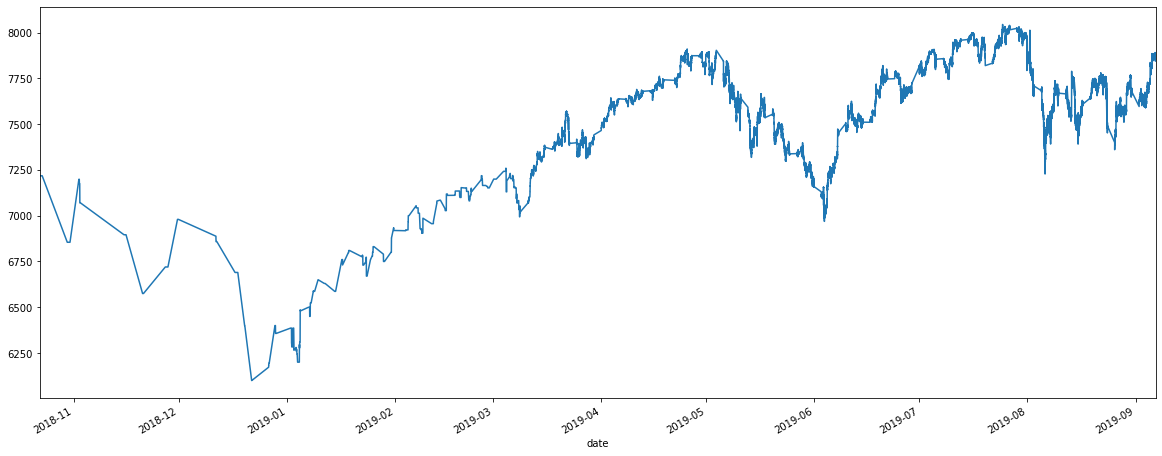

In [6]:
nq.close.plot(figsize=(20,8));

In [7]:
data = pd.DataFrame(nq.close)
data['max'] = data.close.rolling(200).max()
data['min'] = data.close.rolling(200).min()
data['ema'] = data.close.rolling(2000).mean()
#data['mean'] = (data['max'] + data['min']) / 2
#data['indicator'] = (data['close'] - data['mean']) / (data['max'] - data['min'])

data.tail()

,close,max,min,ema
date,,,,
2019-09-06 16:57:00,7867.50,7891.25,7844.5,7849.956750
2019-09-06 16:58:00,7868.00,7891.25,7844.5,7849.983000
2019-09-06 16:59:00,7869.75,7891.25,7844.5,7850.010000
2019-09-06 17:00:00,7869.75,7891.25,7844.5,7850.036750
2019-09-06 17:01:00,7870.50,7891.25,7844.5,7850.063375


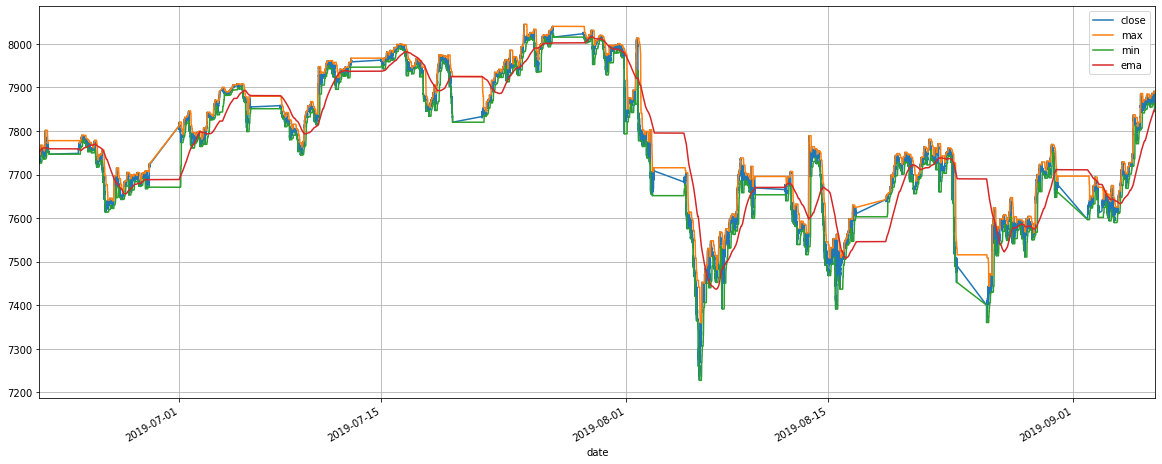

In [8]:
data[-75000:].plot(figsize=(20,8), grid=True);

In [9]:
avg_vol = nq.loc['20190621':].volume.rolling(15).sum().mean()
avg_vol

4940.925950969863

9881.436770634415


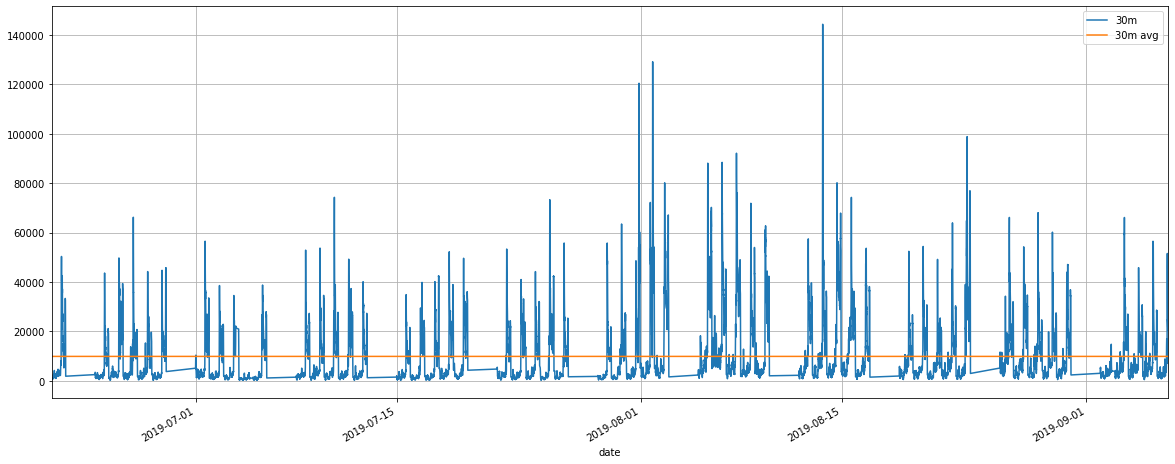

In [10]:
time_int = 30
df = nq.loc['20190621':]
avg = df.volume.rolling(time_int).sum().mean()
volume_df = pd.DataFrame({
    '{}m'.format(time_int): df.volume.rolling(time_int).sum(),
    '{}m avg'.format(time_int): avg,
})
print(avg)
volume_df.plot(figsize=(20, 8), grid=True);

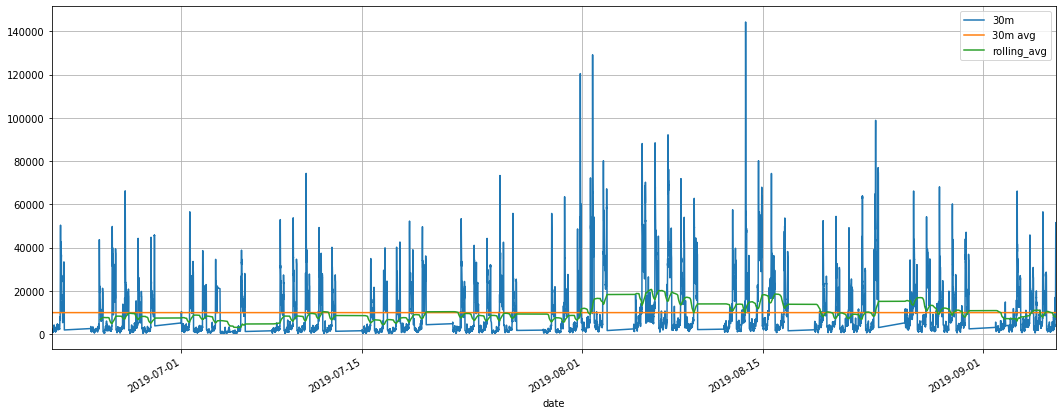

In [11]:
volume_df['rolling_avg'] = volume_df.iloc[:,0].rolling(2400).mean()
volume_df.plot(figsize=(18,7), grid=True);

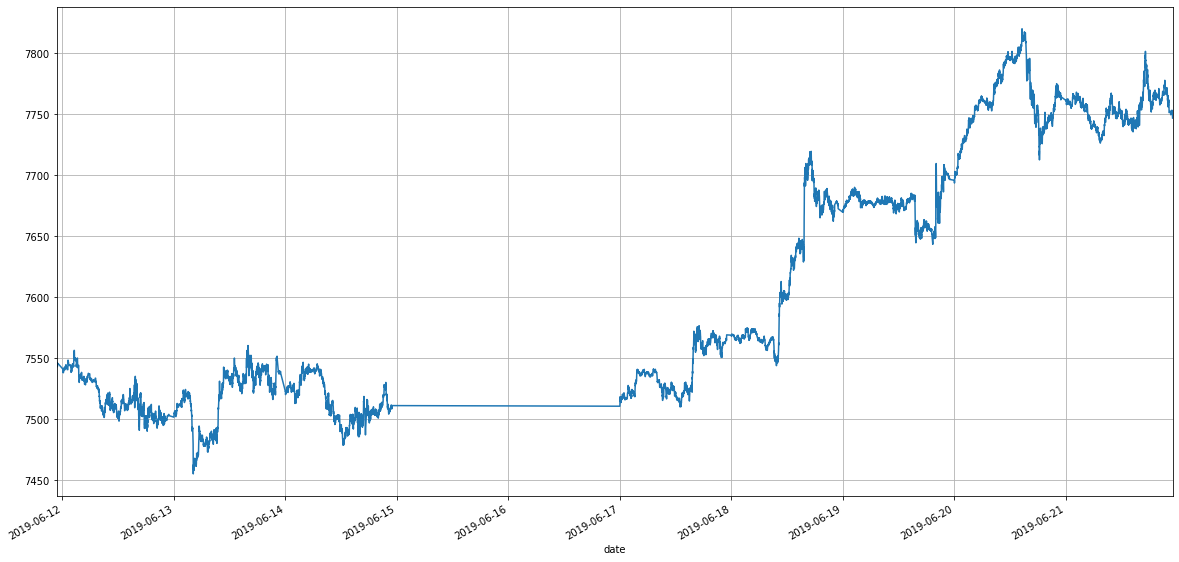

In [12]:
 nq.loc['20190611 22:45:00':'20190621'].close.plot(figsize=(20,10),grid=True);

In [13]:
class VolumeGrouper:
    def __init__(self, avg_vol):
        self.volume = 0
        self.counter = 0
        self.avg_vol = avg_vol
    def group(self, vol):
        self.volume += vol
        if self.volume >= self.avg_vol:
            self.volume -= self.avg_vol
            self.counter += 1
        return self.counter

In [14]:
vol_candles = nq.copy().reset_index()
vol_candles['turnover'] = vol_candles.close * vol_candles.volume
grouper = VolumeGrouper(avg_vol)
vol_candles['label'] = vol_candles.volume.apply(grouper.group)

In [15]:
vol_candles = vol_candles.groupby('label').agg({'date': 'last',
                                  'open': 'first',
                                 'high': 'max',
                                 'low': 'min',
                                 'close': 'last',
                                 'volume': 'sum',
                                'turnover': 'sum'})
vol_candles['avg_price'] = vol_candles.turnover / vol_candles.volume

In [16]:
#vol_candles.set_index('date', inplace=True)

In [17]:
vol_candles.head()

,date,open,high,low,close,volume,turnover,avg_price
label,,,,,,,,
0,2019-04-04 20:54:00,7218.00,7644.00,6099.75,7587.75,4940,36502997.50,7389.270749
1,2019-05-02 17:24:00,7599.00,7910.75,7587.00,7770.00,4938,38399980.50,7776.423755
2,2019-05-13 08:13:00,7768.50,7903.50,7464.00,7539.00,4944,38007932.50,7687.688612
3,2019-05-21 16:10:00,7544.75,7666.75,7318.50,7459.50,4852,36331739.75,7487.992529
4,2019-05-31 13:11:00,7455.00,7510.00,7160.00,7180.50,5011,36762396.25,7336.339304


In [18]:
vol_candles['close'] = vol_candles['avg_price']

In [19]:
data = pd.DataFrame(vol_candles.close)
data['max'] = data.close.rolling(20).max()
data['min'] = data.close.rolling(20).min()
data['ema_fast'] = data.close.ewm(span=80).mean()
data['ema_slow'] = data.close.ewm(span=480).mean()
#data.reset_index(drop=True, inplace=True)
data.tail()

,close,max,min,ema_fast,ema_slow
label,,,,,
5388,7859.888850,7886.495094,7844.839616,7853.024360,7736.470892
5389,7864.549771,7876.540282,7844.839616,7853.308938,7737.003445
5390,7871.655682,7876.540282,7844.839616,7853.761944,7737.563329
5391,7872.893730,7875.310408,7844.839616,7854.234333,7738.126034
5392,7868.772024,7872.893730,7844.839616,7854.593289,7738.669260


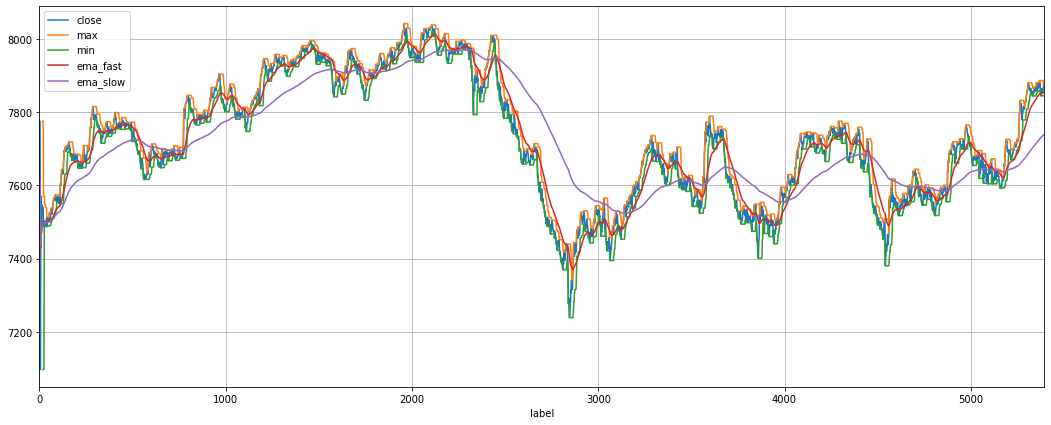

In [20]:
data.plot(figsize=(18,7), grid=True);

In [21]:
ema_diff = pd.DataFrame({'close': data['close'], 'ema_diff': data['ema_fast'] - data['ema_slow']})
ema_diff['return'] = ema_diff['close'].pct_change()
ema_diff['std'] = ema_diff['return'].expanding().std()
ema_diff['price_std'] = ema_diff['std'] * ema_diff['close']
ema_diff['norm'] = ema_diff['ema_diff']/ema_diff['price_std']
ema_diff['zscore'] = (ema_diff['ema_diff'] - ema_diff['ema_diff'].expanding().mean()) / ema_diff['ema_diff'].expanding().std()
#ema_diff['max']

In [22]:
ema_diff.tail()

,close,ema_diff,return,std,price_std,norm,zscore
label,,,,,,,
5388,7859.888850,116.553467,0.000046,0.001531,12.035451,9.684179,1.633204
5389,7864.549771,116.305493,0.000593,0.001531,12.041631,9.658616,1.629059
5390,7871.655682,116.198614,0.000904,0.001531,12.051772,9.641621,1.626961
5391,7872.893730,116.108300,0.000157,0.001531,12.052559,9.633498,1.625104
5392,7868.772024,115.924029,-0.000524,0.001531,12.045269,9.624030,1.621890


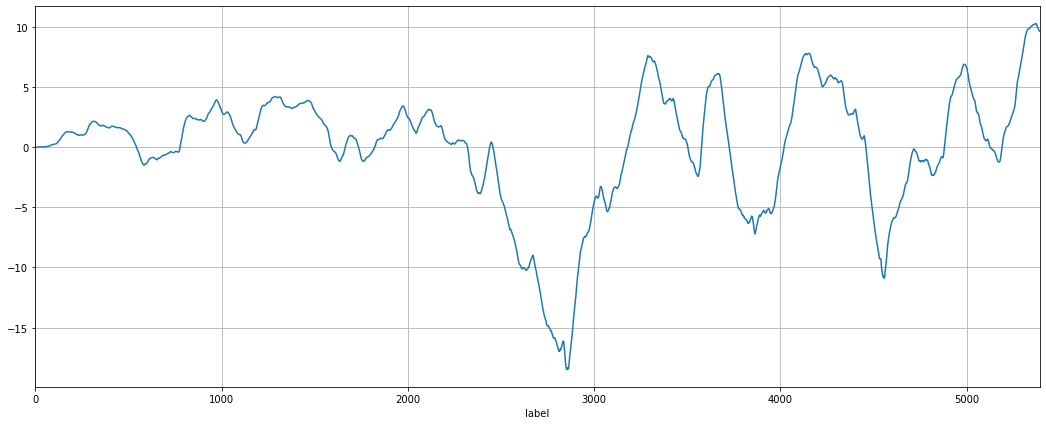

In [23]:
ema_diff['norm'].plot(figsize=(18,7), grid=True);

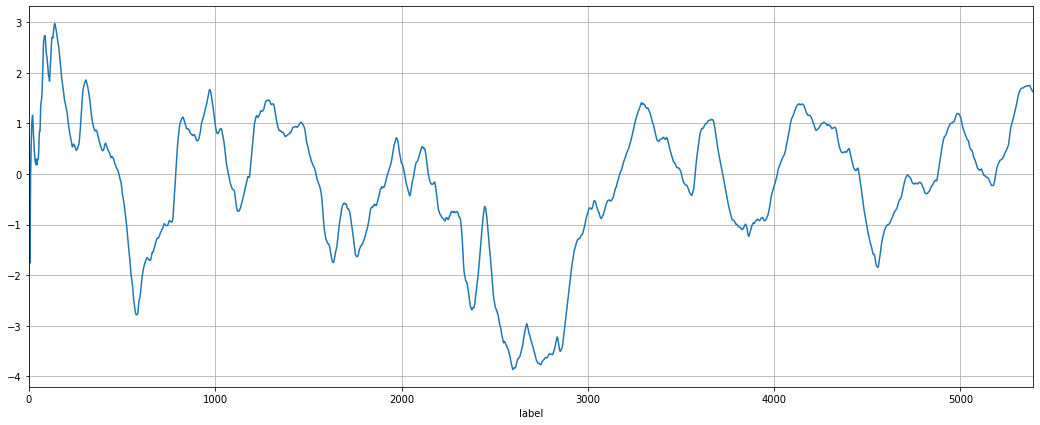

In [24]:
ema_diff['zscore'].plot(figsize=(18,7), grid=True);

In [25]:
def get_forecast(close, periods):
    ind = pd.DataFrame({'close': close})
    ind['max'] = ind.close.rolling(periods).max()
    ind['min'] = ind.close.rolling(periods).min()
    ind['mean'] = (ind['max'] + ind['min']) / 2
    ind['forecast'] = (ind['close'] - ind['mean']) / (ind['max'] - ind['min'])
    return ind

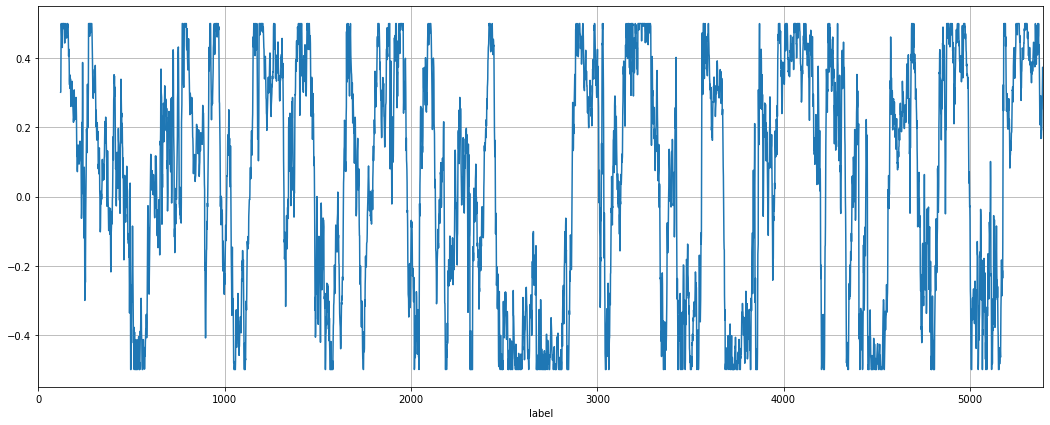

In [26]:
ind = get_forecast(data.close, 120)
ind.forecast.plot(figsize=(18,7), grid=True);

In [27]:
10 / ind.forecast.abs().mean()

33.282987326673194

In [28]:
10 / ema_diff.zscore.abs().mean()

9.515916109055423

In [29]:
10 / ema_diff.norm.abs().mean()

2.7574137637197613

In [30]:
ind['ind'] = ind['forecast'] * 40 + ema_diff['norm'] * 5.6

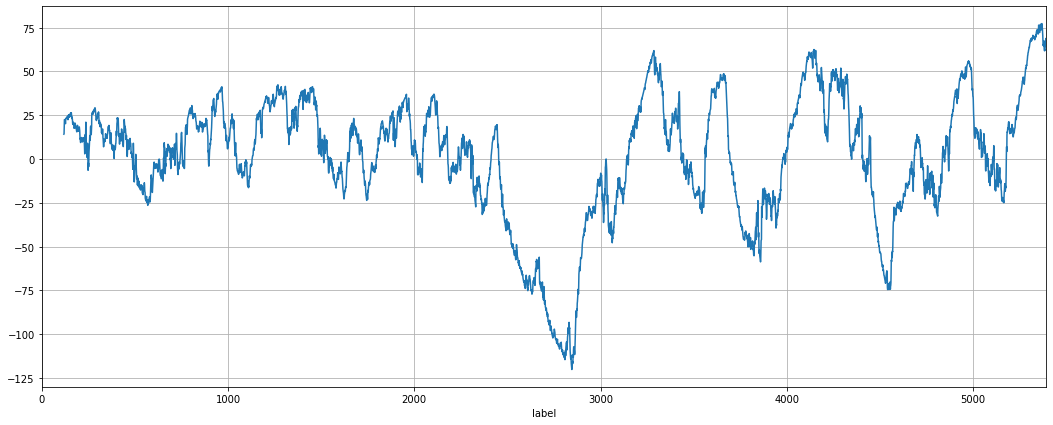

In [31]:
ind.ind.plot(figsize=(18, 7), grid=True);

In [32]:
norm_ind = pd.DataFrame({'breakout': ind['forecast'] * 40, 'ema_cross': ema_diff['norm'] * 5.6})
norm_ind['ema_cross'] = norm_ind['ema_cross'].clip(lower=-20, upper=20)
norm_ind['ema_cross_shift'] = norm_ind['ema_cross'].shift(20)
norm_ind.tail()

,breakout,ema_cross,ema_cross_shift
label,,,
5388,10.119208,20.0,20.0
5389,11.850140,20.0,20.0
5390,14.489070,20.0,20.0
5391,14.948845,20.0,20.0
5392,13.418163,20.0,20.0


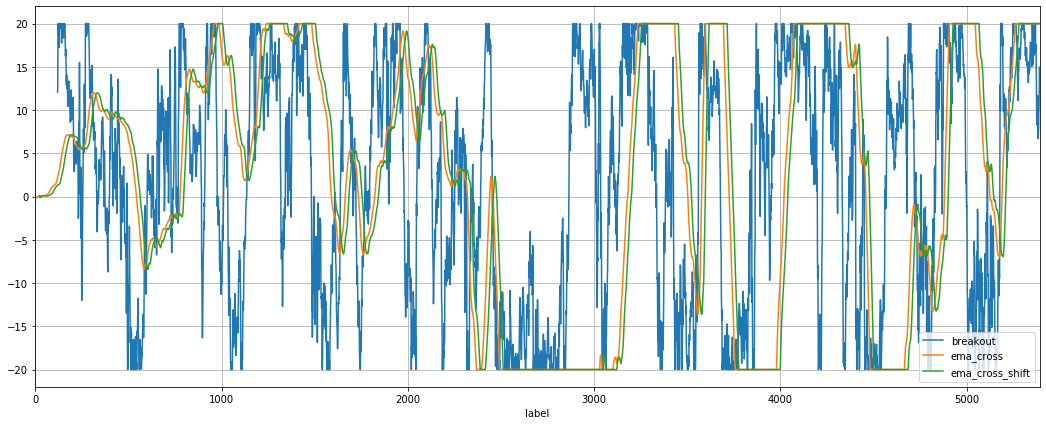

In [33]:
norm_ind.plot(figsize=(18,7), grid=True);

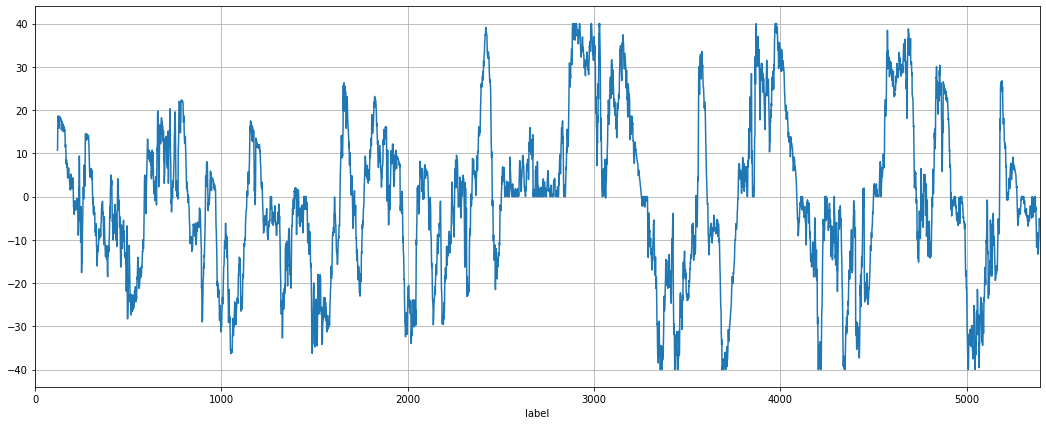

In [34]:
(norm_ind['breakout'] - norm_ind['ema_cross_shift']).plot(figsize=(18,7), grid=True);

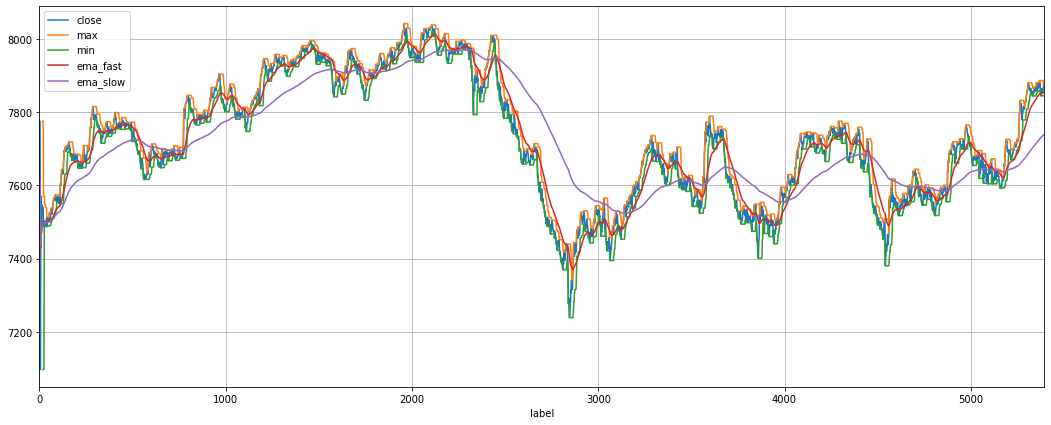

In [35]:
data.plot(figsize=(18,7), grid=True);

In [36]:
periods = [7, 15, 30, 120, 240, 480]

In [37]:
forecasts = pd.DataFrame()
for period in periods:
    forecasts[period] = get_forecast(data.close, period)['forecast']
forecasts.tail()

,7,15,30,120,240,480
label,,,,,,
5388,0.500000,0.284046,-0.138721,0.252980,0.409523,0.409523
5389,0.500000,0.500000,-0.026829,0.296253,0.425373,0.425373
5390,0.500000,0.500000,0.143758,0.362227,0.449537,0.449537
5391,0.500000,0.500000,0.173480,0.373721,0.453747,0.453747
5392,0.288777,0.332666,0.074532,0.335454,0.439731,0.439731


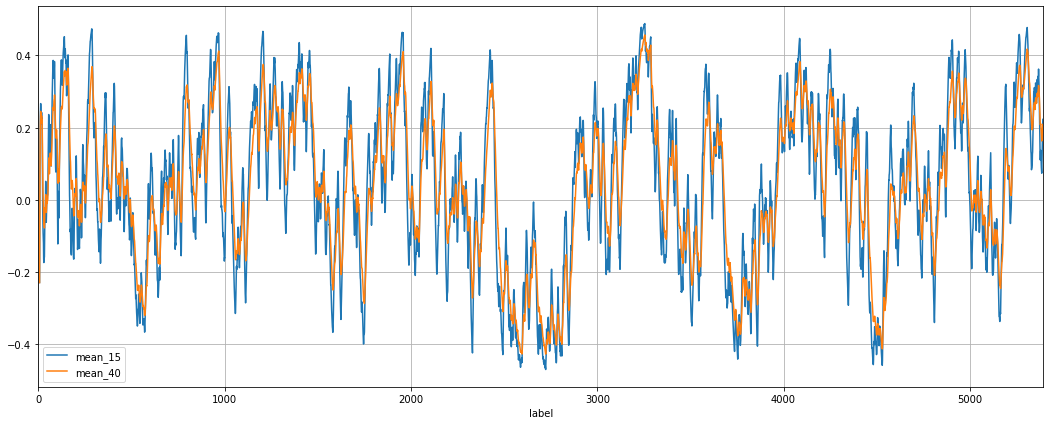

In [38]:
x = pd.DataFrame({'mean_15': forecasts.mean(axis=1).ewm(span=15).mean(),
                  'mean_40': forecasts.mean(axis=1).ewm(span=40).mean()
                  #'forecast': forecasts.mean(axis=1)
                 })
x.plot(figsize=(18,7),grid=True);

In [39]:
forecasts.corr()

,7,15,30,120,240,480
7,1.000000,0.804758,0.615965,0.331578,0.255976,0.205587
15,0.804758,1.000000,0.842129,0.489620,0.380446,0.302066
30,0.615965,0.842129,1.000000,0.671381,0.534138,0.421578
120,0.331578,0.489620,0.671381,1.000000,0.863877,0.663661
240,0.255976,0.380446,0.534138,0.863877,1.000000,0.817499
480,0.205587,0.302066,0.421578,0.663661,0.817499,1.000000


In [40]:
def get_emas(close, periods):
    ind = pd.DataFrame({'close': close})
    ind['ema_fast'] = close.ewm(span=periods[0]).mean()
    ind['ema_slow'] = close.ewm(span=periods[1]).mean()
    ind['diff'] = ind['ema_fast'] - ind['ema_slow']
    return ind

In [41]:
ema_pairs = [(60, 240), (120, 640), (360, 1120)]

In [42]:
emas = pd.DataFrame()
for pair in ema_pairs:
    emas[pair] = get_emas(data.close, pair)['diff']
emas.tail()

,"(60, 240)","(120, 640)","(360, 1120)"
label,,,
5388,67.839095,121.553168,76.425975
5389,67.419925,121.542648,76.686369
5390,67.173529,121.621349,76.970791
5391,66.949230,121.708835,77.257021
5392,66.614936,121.733063,77.524912


In [43]:
emas.corr()

,"(60, 240)","(120, 640)","(360, 1120)"
"(60, 240)",1.000000,0.808690,0.405796
"(120, 640)",0.808690,1.000000,0.819887
"(360, 1120)",0.405796,0.819887,1.000000


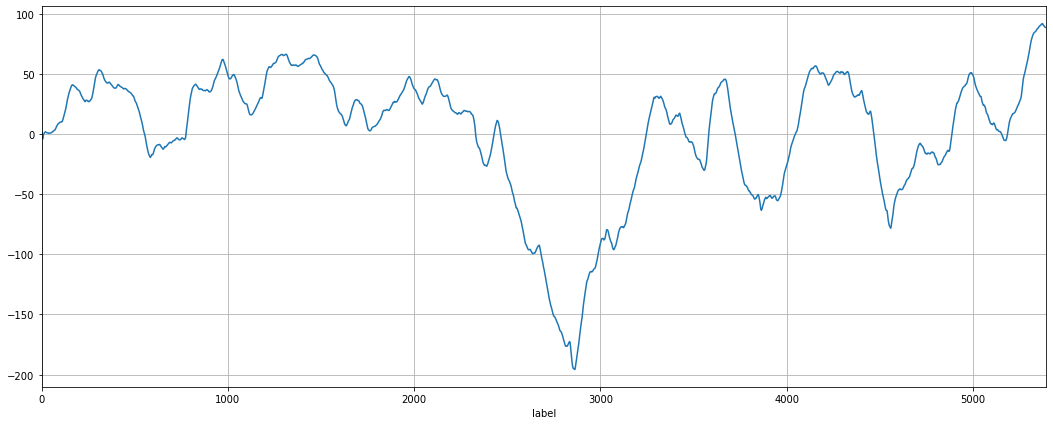

In [44]:
emas.mean(axis=1).plot(figsize=(18,7), grid=True);

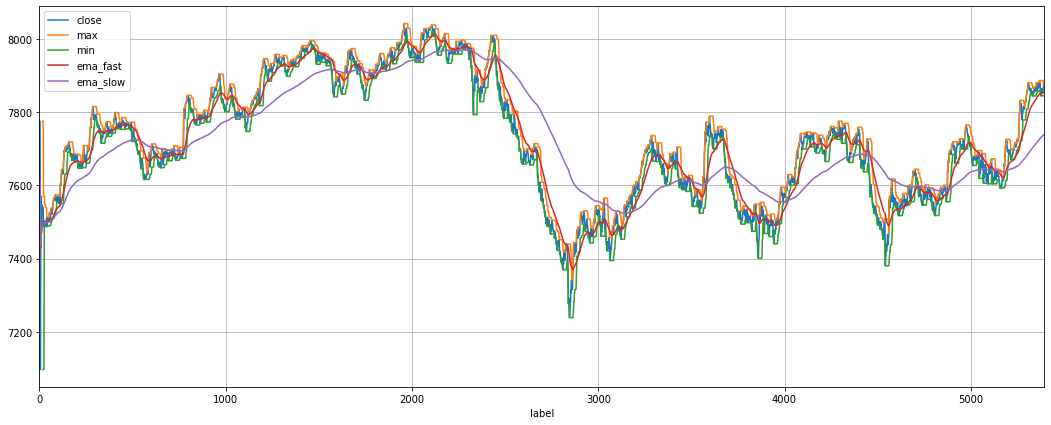

In [45]:
data.plot(figsize=(18,7), grid=True);

In [46]:
10/ emas.mean(axis=1).abs().mean()

0.24299762779754933

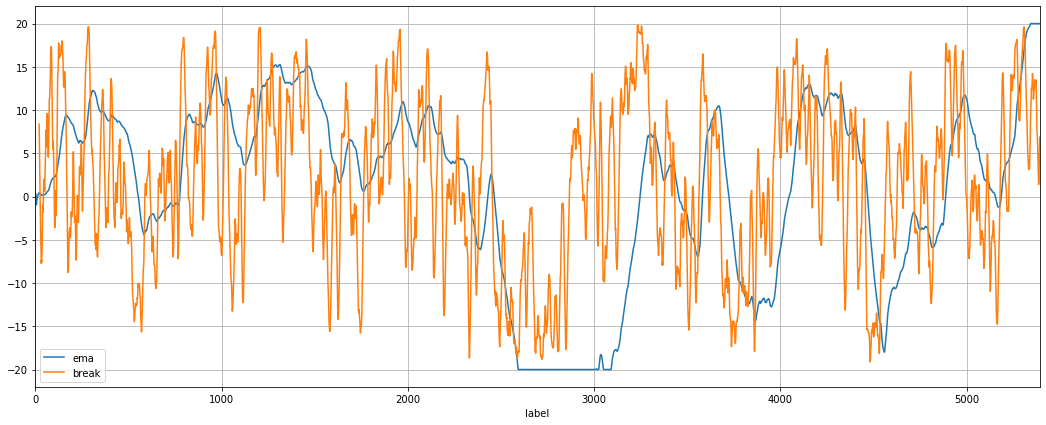

In [47]:
indices = pd.DataFrame({'ema': (emas.mean(axis=1) * .23).clip(lower=-20, upper=20),
                       'break': forecasts.mean(axis=1).rolling(15).mean() * 40
                       })
indices.plot(figsize=(18,7), grid=True);

In [48]:
indices.corr()

,ema,break
ema,1.000000,0.423887
break,0.423887,1.000000


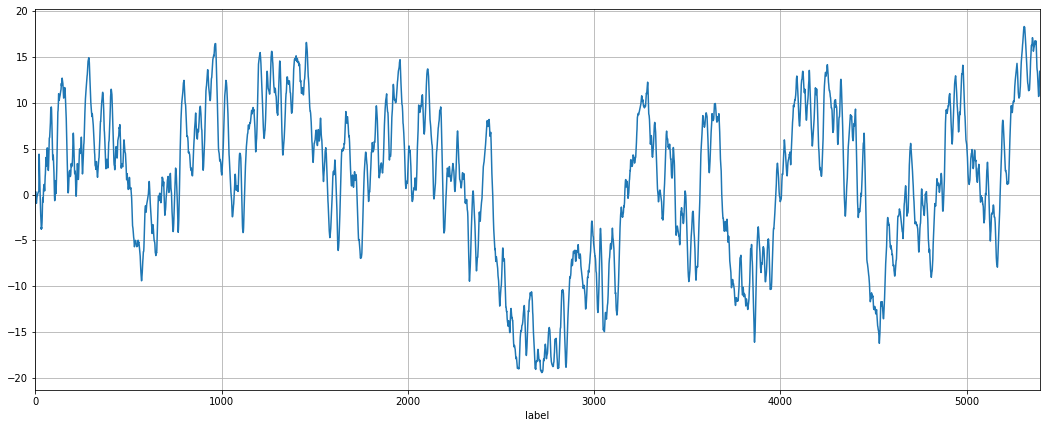

In [49]:
indices.mean(axis=1).plot(figsize=(18,7), grid=True);

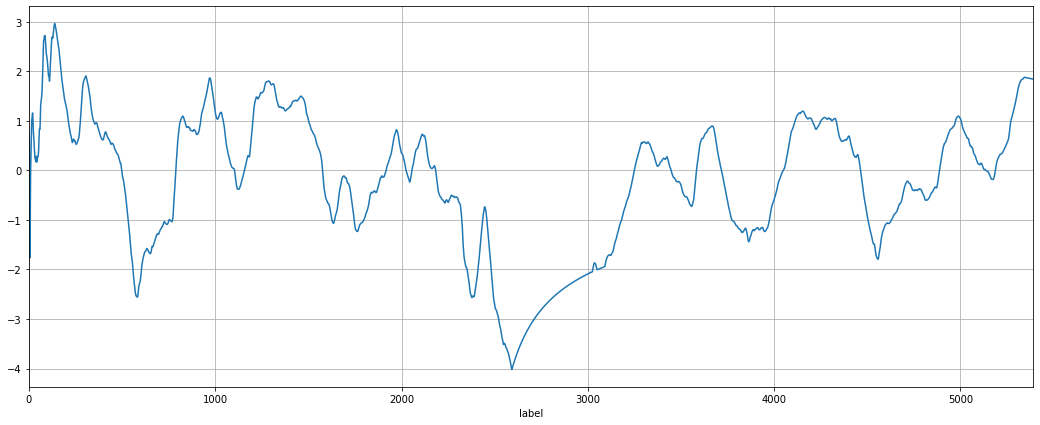

In [50]:
((indices['ema'] - indices['ema'].expanding().mean()) / indices['ema'].expanding().std()).plot(figsize=(18,7), grid=True);

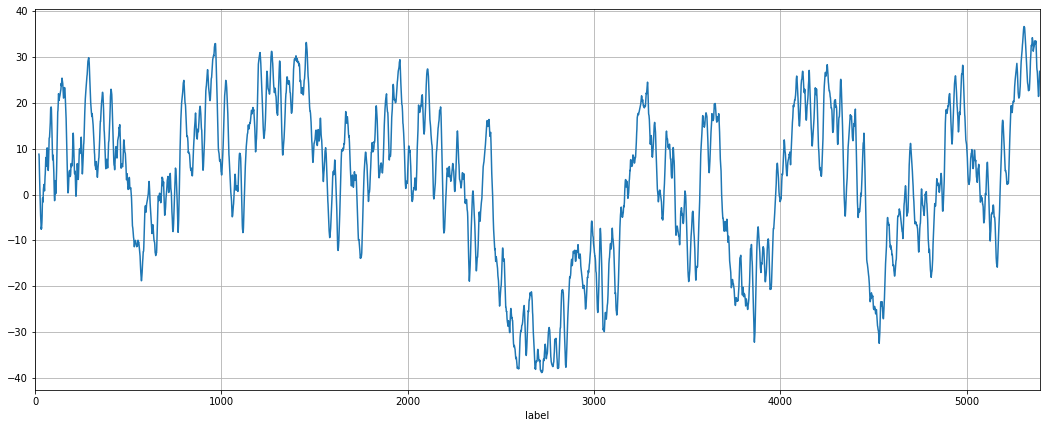

In [51]:
(indices['ema'] + indices['break']).plot(figsize=(18,7), grid=True);

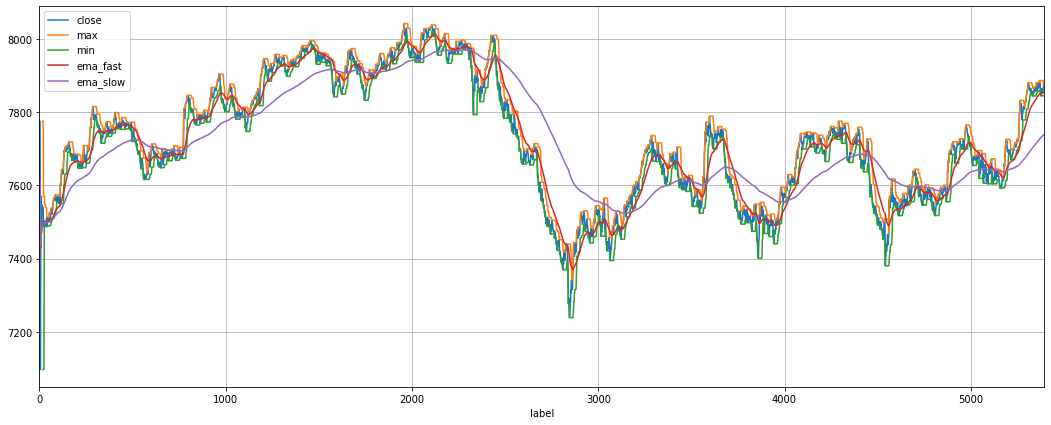

In [52]:
data.plot(figsize=(18,7), grid=True);

In [53]:
def get_ATR(data, periods):
    TR = pd.DataFrame({'A': (data['high'] - data['low']),
                       'B': (data['high'] - data['close']).abs(),
                       'C': (data['low'] - data['close']).abs()
                      })
    TR['TR'] = TR.max(axis=1)
    TR['ATR'] = TR['TR'].rolling(periods).mean()
    return TR.ATR

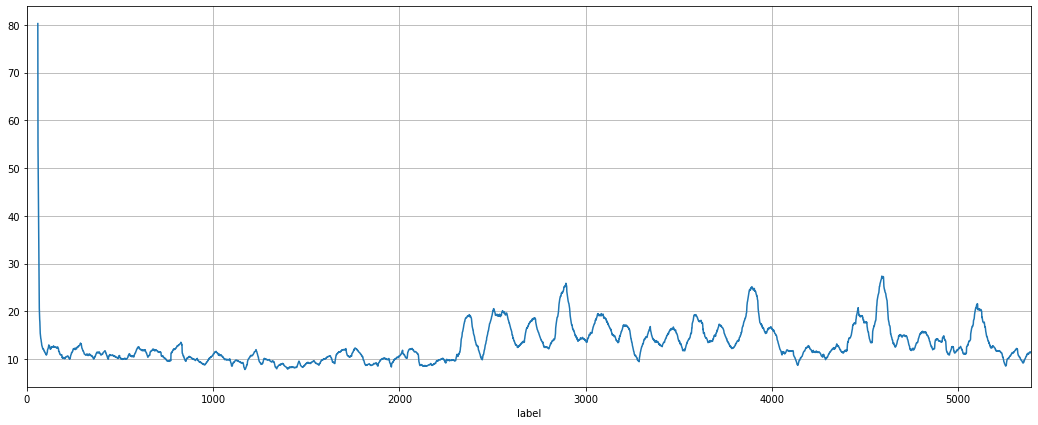

In [54]:
get_ATR(vol_candles, 60).plot(figsize=(18,7), grid=True);

In [55]:
def get_std(data, periods):
    returns = np.log(data.avg_price.pct_change()+1)
    return returns.rolling(periods).std() * data.avg_price

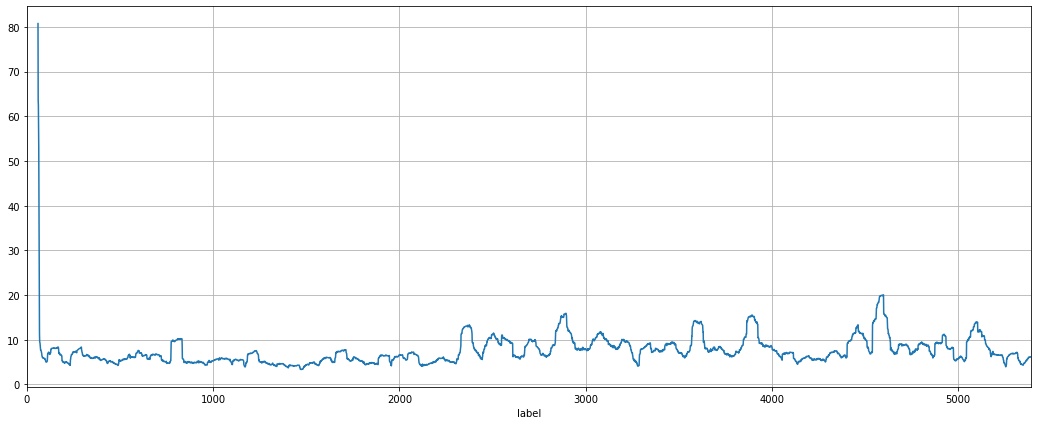

In [56]:
get_std(vol_candles, 60).plot(figsize=(18,7), grid=True);

In [57]:
vol_indicators = pd.DataFrame({'ATR': get_ATR(vol_candles, 80), 
                               'std': get_std(vol_candles, 80)})

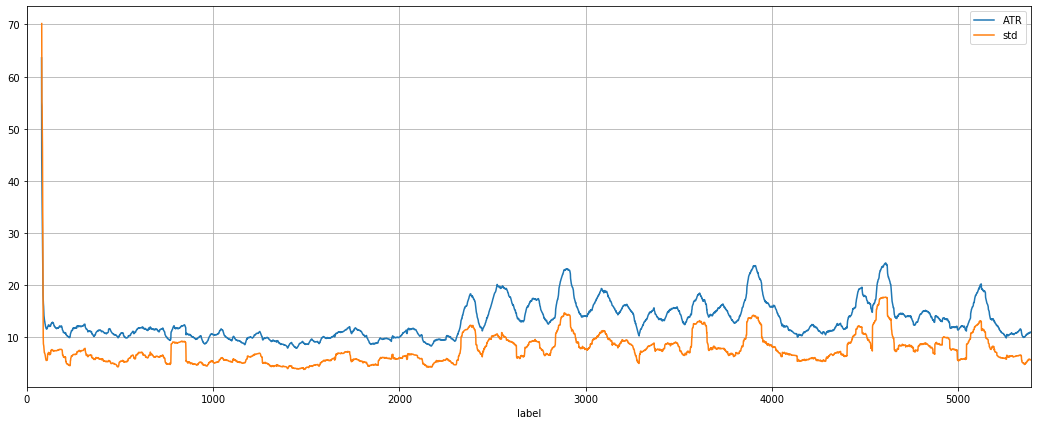

In [58]:
vol_indicators.plot(figsize=(18,7), grid=True);

In [59]:
vol_indicators.corr()

,ATR,std
ATR,1.000000,0.886723
std,0.886723,1.000000


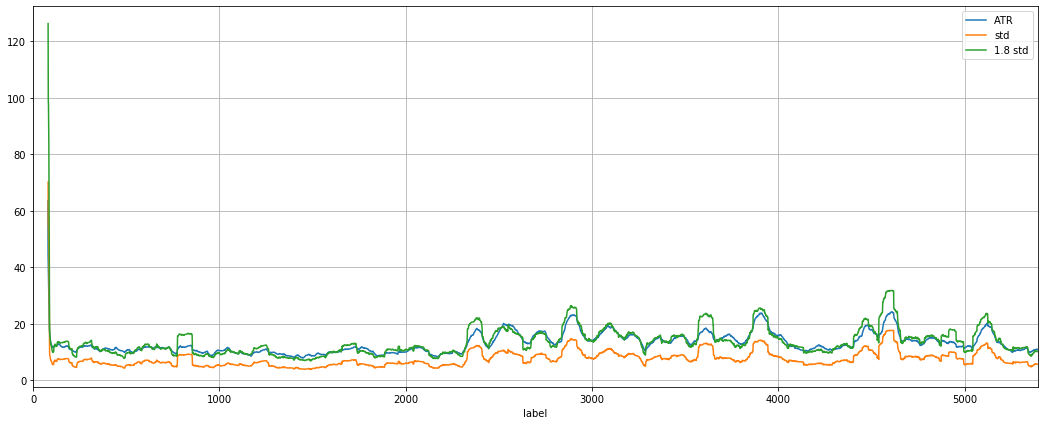

In [60]:
vol_indicators['1.8 std'] = vol_indicators['std'] * 1.8
vol_indicators.plot(figsize=(18,7), grid=True);

In [61]:
vol_indicators.corr()

,ATR,std,1.8 std
ATR,1.000000,0.886723,0.886723
std,0.886723,1.000000,1.000000
1.8 std,0.886723,1.000000,1.000000


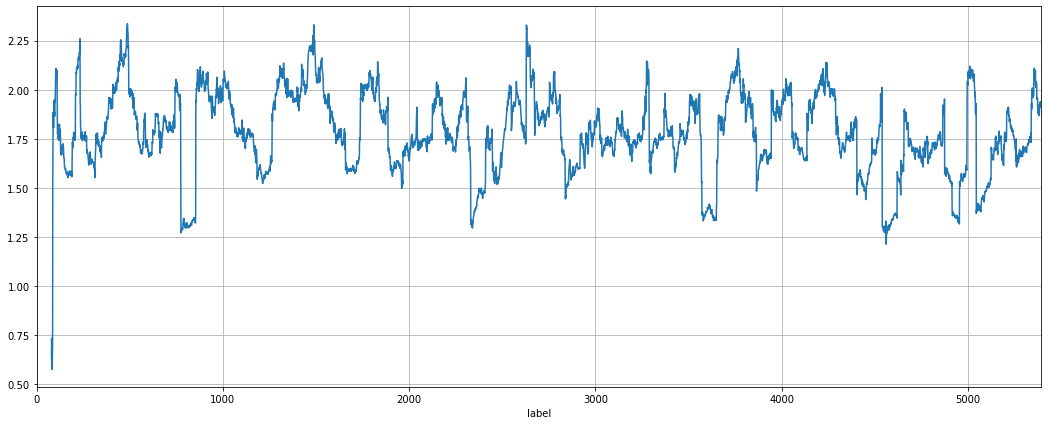

In [62]:
(vol_indicators['ATR'] / vol_indicators['std']).plot(figsize=(18,7), grid=True);

In [63]:
periods = [10, 20, 40,]

In [64]:
multi_period = pd.DataFrame({'close': data.close})

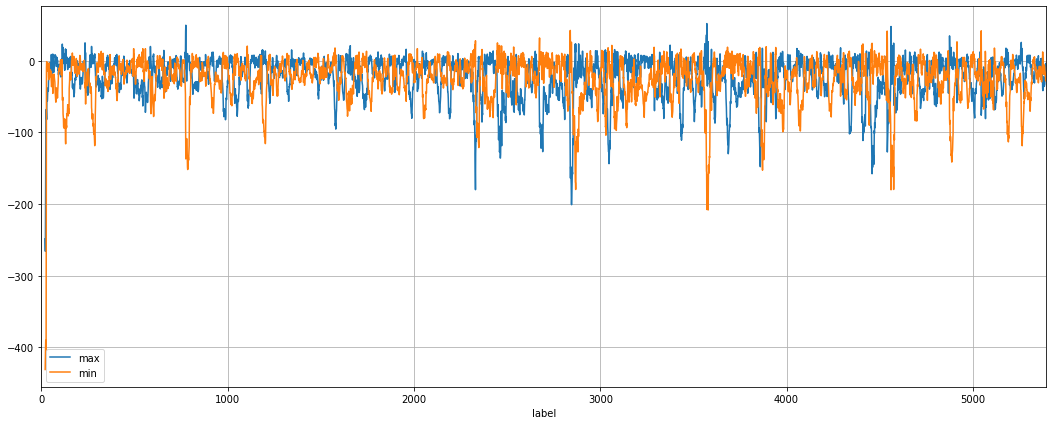

In [65]:
multi_period['max'] = multi_period.close - multi_period.close.shift(1).rolling(20).max()
multi_period['min'] = multi_period.close.shift(1).rolling(20).min() - multi_period.close
multi_period[['max', 'min']].plot(figsize=(18,7), grid=True);

In [66]:
multi_period_max = pd.DataFrame({'close': data.close})
multi_period_min = pd.DataFrame({'close': data.close})
for period in periods:
    multi_period_max[period] = multi_period.close - multi_period.close.shift(1).rolling(period).max()
    multi_period_min[period] = multi_period.close.shift(1).rolling(20).min() - multi_period.close
multi_period_avg = pd.DataFrame({
    #'close': data.close,
    'max': multi_period_max.mean(axis=1).clip(upper=2200, lower=800),
    'min': multi_period_min.mean(axis=1).clip(upper=2200, lower=800),
})
multi_period_avg.tail()

,max,min
label,,
5388,1950.632819,1953.685287
5389,1955.293739,1951.354827
5390,1964.759395,1947.801871
5391,1964.220965,1947.182847
5392,1960.097216,1949.243700


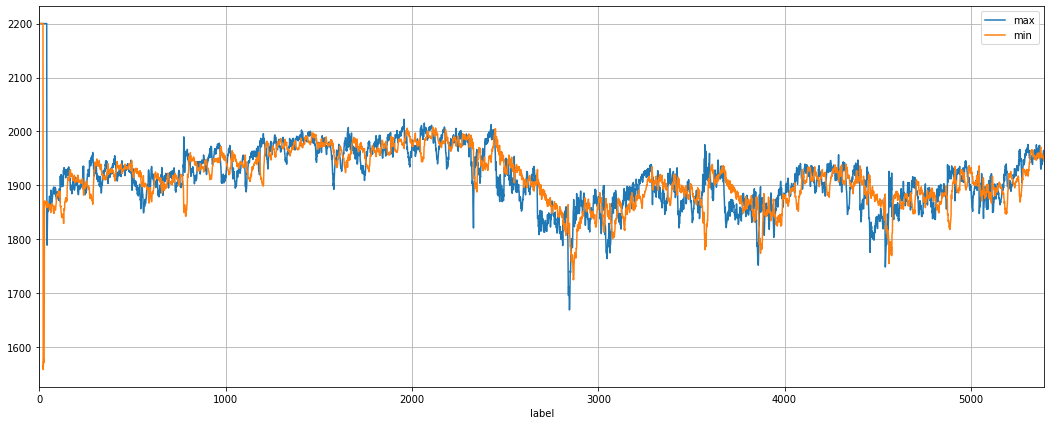

In [67]:
multi_period_avg.plot(figsize=(18,7), grid=True);

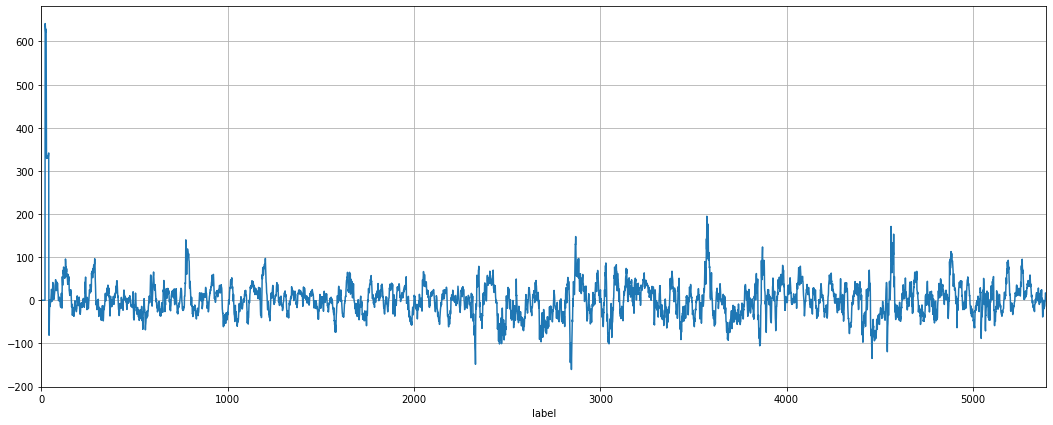

In [68]:
(multi_period_avg['max'] - multi_period_avg['min']).plot(figsize=(18,7), grid=True);

In [69]:
from functools import partial

def get_min_max(data, period):
    return pd.DataFrame({
        'max': (data - data.shift(1).rolling(period).max()) > 0,
        'min': (data.shift(1).rolling(period).min() - data) > 0
    })

def majority_function(data):
    return (0.5 + ((data.sum(axis=1) - 0.5) / data.count(axis=1))).apply(np.floor)

def get_min_max_df(data, periods, func=get_min_max):
    min_max_func = partial(func, data)
    mins = pd.DataFrame()
    maxs = pd.DataFrame()
    for period in periods:
        df = min_max_func(period)
        mins[period] = df['min']
        maxs[period] = df['max']
    return {'min': mins,
           'max': maxs}

def get_signals(data, periods, func=get_min_max_df):
    min_max = func(data, periods)
    #return min_max['min']
    
    return pd.DataFrame({
        'signal': majority_function(min_max['max']) - majority_function(min_max['min'])
    })
    

In [70]:
periods

[10, 20, 40]

In [71]:
get_min_max_df(data.close, periods)

{'min':           10     20     40
 label                     
 0      False  False  False
 1      False  False  False
 2      False  False  False
 3      False  False  False
 4      False  False  False
 ...      ...    ...    ...
 5388   False  False  False
 5389   False  False  False
 5390   False  False  False
 5391   False  False  False
 5392   False  False  False
 
 [5393 rows x 3 columns], 'max':           10     20     40
 label                     
 0      False  False  False
 1      False  False  False
 2      False  False  False
 3      False  False  False
 4      False  False  False
 ...      ...    ...    ...
 5388   False  False  False
 5389    True  False  False
 5390    True  False  False
 5391    True  False  False
 5392   False  False  False
 
 [5393 rows x 3 columns]}

In [72]:
get_signals(data.close, periods)

,signal
label,
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
5388,0.0
5389,0.0
5390,0.0


In [73]:
get_signals(data.close, periods).tail()

,signal
label,
5388,0.0
5389,0.0
5390,0.0
5391,0.0
5392,0.0


In [74]:
signals = pd.DataFrame({
    'close': data.close,
    'signal': get_signals(data.close, periods)['signal']
})

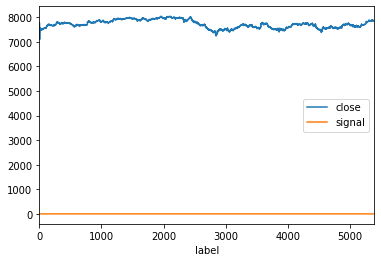

In [75]:
signals.plot();

In [76]:
signals['value'] = signals['close'] * signals['signal']

In [77]:
signals.tail()

,close,signal,value
label,,,
5388,7859.888850,0.0,0.0
5389,7864.549771,0.0,0.0
5390,7871.655682,0.0,0.0
5391,7872.893730,0.0,0.0
5392,7868.772024,0.0,0.0


In [78]:
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)

In [79]:
signals['buy'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['sell'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)

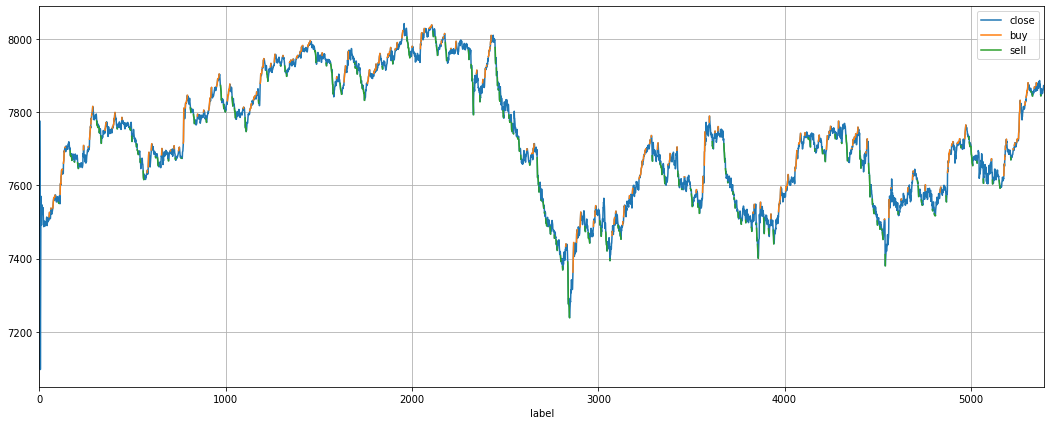

In [80]:
signals[['close', 'buy', 'sell']].plot(figsize=(18, 7), grid=True);

In [81]:
signals['cum_signal'] = signals.signal.expanding().apply(lambda x: x.sum().clip(min=-1, max=1), raw=False)

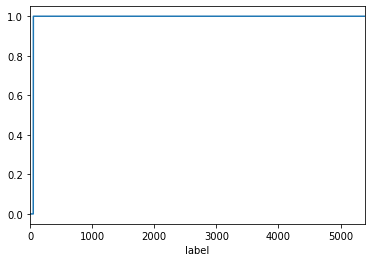

In [82]:
signals['cum_signal'].plot()

In [83]:
#signals['filter'] = np.sign(emas.mean(axis=1))
signals['filter'] = np.sign(data.close - data.ema_fast)
signals['atr'] = get_ATR(vol_candles, 80)

In [84]:
number_of_trades = 0
entry = 0
for row in signals.itertuples():
    if row.Index == 0:
        continue
    # if there's no position signal is to be filtered
    if signals.loc[row.Index-1, 'cum_signal'] == 0 and row.filter * row.signal != 1:
        signals.loc[row.Index, 'cum_signal'] = 0
        continue
    else:
        signals.loc[row.Index, 'cum_signal'] = (signals.loc[row.Index-1, 'cum_signal'] + row.signal).clip(max=1, min=-1)
        
    # create stop loss
    if signals.loc[row.Index, 'cum_signal'] - signals.loc[row.Index-1, 'cum_signal'] != 0:
        sl = signals.loc[row.Index, 'close'] - signals.loc[row.Index, 'cum_signal'] * signals.loc[row.Index, 'atr'] * 1
        signals.loc[row.Index, 'sl'] = sl
    if not signals.loc[row.Index, 'sl']:
        signals.loc[row.Index, 'sl'] = signals.loc[row.Index-1, 'sl']
        
    # apply stop loss
    if signals.loc[row.Index, 'cum_signal'] == 1 and signals.loc[row.Index, 'close'] < sl:
        signals.loc[row.Index, 'cum_signal'] = 0
    elif signals.loc[row.Index, 'cum_signal'] == -1 and signals.loc[row.Index, 'close'] > sl:
        signals.loc[row.Index, 'cum_signal'] = 0
        
    # count trades
    if signals.loc[row.Index, 'cum_signal'] != signals.loc[row.Index-1, 'cum_signal']:
        number_of_trades += 1

In [85]:
signals.tail()

,close,signal,value,buy,sell,cum_signal,filter,atr,sl
label,,,,,,,,,
5388,7859.888850,0.0,NaN,NaN,NaN,0.0,1.0,10.909375,NaN
5389,7864.549771,0.0,NaN,NaN,NaN,0.0,1.0,10.900000,NaN
5390,7871.655682,0.0,NaN,NaN,NaN,0.0,1.0,10.934375,NaN
5391,7872.893730,0.0,NaN,NaN,NaN,0.0,1.0,10.946875,NaN
5392,7868.772024,0.0,NaN,NaN,NaN,0.0,1.0,10.859375,NaN


In [86]:
signals['value'] = signals['close'] * signals['cum_signal']
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)
signals['long'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['short'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)

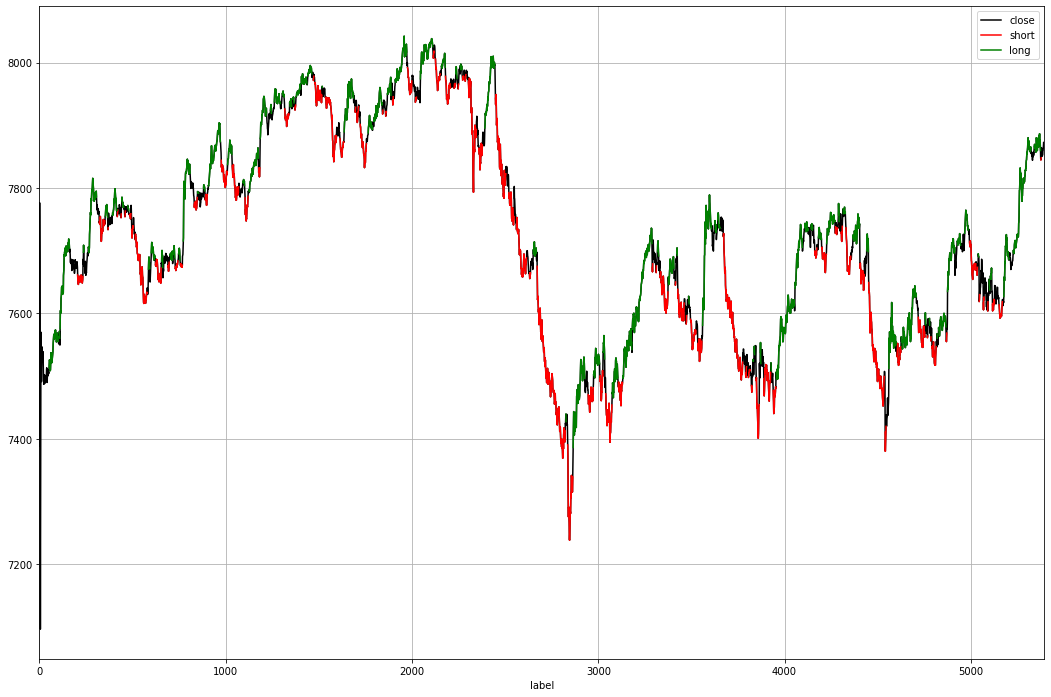

In [87]:
signals[['close', 'short', 'long']].plot(figsize=(18, 12), grid=True, color=['k', 'r', 'g']);

In [88]:
#signals.tail(200)

In [89]:
signals.head()

,close,signal,value,buy,sell,cum_signal,filter,atr,sl,long,short
label,,,,,,,,,,,
0,7389.270749,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,7776.423755,0.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN
2,7687.688612,0.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN
3,7487.992529,0.0,NaN,NaN,NaN,0.0,-1.0,NaN,NaN,NaN,NaN
4,7336.339304,0.0,NaN,NaN,NaN,0.0,-1.0,NaN,NaN,NaN,NaN


In [90]:
signals['long_pnl'] = signals.long.diff().fillna(0)
signals['short_pnl'] = - signals.short.diff().fillna(0)

In [91]:
long_pnl = signals.long_pnl.sum()
short_pnl = signals.short_pnl.sum()
pnl = long_pnl + short_pnl
long_pnl, short_pnl, pnl

(1654.87526016225, 1109.6553539806873, 2764.5306141429373)

fast filter: 773 (980 with 60minute volumes)
slow filter: 404

In [92]:
signals['pnl'] = signals['long_pnl'] + signals['short_pnl']
pnl_p = signals[signals['pnl']>0].pnl
pnl_m = signals[signals['pnl']<0].pnl
pnl_p.count(), pnl_m.count(), pnl_p.count()/(pnl_p.count()+pnl_m.count())

(2015, 1825, 0.5247395833333334)

In [93]:
pnl_p.sum(), pnl_m.sum(), pnl_p.sum()/ pnl_m.abs().sum()

(12048.520246796586, -9283.98963265365, 1.2977739876420726)

In [94]:
signals['date'] = vol_candles['date']

In [95]:
signals.set_index('date', inplace=True)

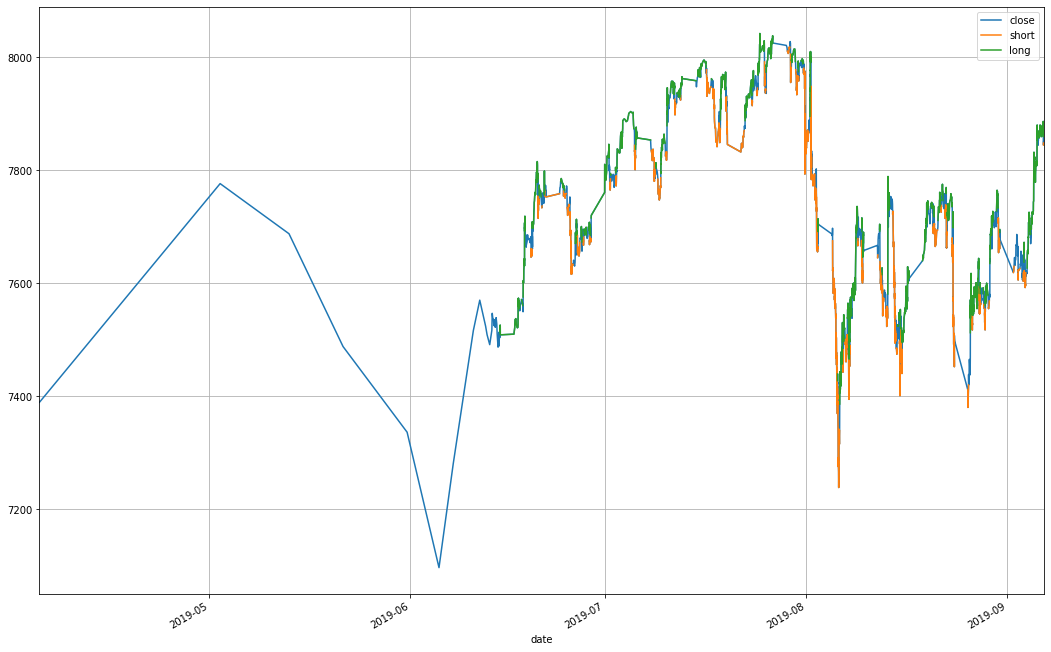

In [96]:
signals[['close', 'short', 'long']].plot(figsize=(18, 12), grid=True);

In [97]:
signals.tail(30)

,close,signal,value,buy,sell,cum_signal,filter,atr,sl,long,short,long_pnl,short_pnl,pnl
date,,,,,,,,,,,,,,
2019-09-06 12:18:00,7864.962603,0.0,7864.962603,NaN,NaN,1.0,1.0,10.375000,NaN,7864.962603,NaN,-12.228423,-0.000000,-12.228423
2019-09-06 13:09:00,7870.214271,0.0,7870.214271,NaN,NaN,1.0,1.0,10.400000,NaN,7870.214271,NaN,5.251668,-0.000000,5.251668
2019-09-06 13:45:00,7877.940012,0.0,7877.940012,NaN,NaN,1.0,1.0,10.356250,NaN,7877.940012,NaN,7.725741,-0.000000,7.725741
2019-09-06 14:17:00,7883.145875,1.0,7883.145875,7883.145875,NaN,1.0,1.0,10.356250,NaN,7883.145875,NaN,5.205863,-0.000000,5.205863
2019-09-06 14:31:00,7876.016092,0.0,7876.016092,NaN,NaN,1.0,1.0,10.490625,NaN,7876.016092,NaN,-7.129783,-0.000000,-7.129783
2019-09-06 14:39:00,7877.533230,0.0,7877.533230,NaN,NaN,1.0,1.0,10.515625,NaN,7877.533230,NaN,1.517138,-0.000000,1.517138
2019-09-06 14:47:00,7886.495094,1.0,7886.495094,7886.495094,NaN,1.0,1.0,10.618750,NaN,7886.495094,NaN,8.961864,-0.000000,8.961864
2019-09-06 15:01:00,7873.064203,0.0,7873.064203,NaN,NaN,1.0,1.0,10.600000,NaN,7873.064203,NaN,-13.430891,-0.000000,-13.430891
2019-09-06 15:22:00,7876.540282,0.0,7876.540282,NaN,NaN,1.0,1.0,10.618750,NaN,7876.540282,NaN,3.476079,-0.000000,3.476079


In [98]:
interval = pd.Series(signals.index).diff().loc[10:]
interval.tail(20)

5373   00:02:00
5374   00:03:00
5375   00:02:00
5376   00:03:00
5377   00:03:00
5378   00:04:00
5379   00:02:00
5380   00:03:00
5381   00:05:00
5382   00:03:00
5383   00:06:00
5384   00:04:00
5385   00:07:00
5386   00:07:00
5387   00:06:00
5388   00:07:00
5389   00:07:00
5390   00:06:00
5391   00:07:00
5392   00:05:00
Name: date, dtype: timedelta64[ns]

In [99]:
interval.mean()

Timedelta('0 days 00:23:01.304105')

In [100]:
daily = pd.DataFrame()
daily['close'] = signals['close'].resample('D').last()
daily['pnl'] = (signals['long_pnl'] + signals['short_pnl']).resample('D').sum()
daily.tail()

,close,pnl
date,,
2019-09-02,7621.603947,-15.787549
2019-09-03,7612.483673,-41.194952
2019-09-04,7723.209151,86.050983
2019-09-05,7857.058754,129.677921
2019-09-06,7868.772024,-0.745919


In [101]:
daily['dollars'] = 0
daily.iloc[0,2] = 25000

In [102]:
daily.head()

,close,pnl,dollars
date,,,
2019-04-04,7389.270749,0.0,25000
2019-04-05,NaN,0.0,0
2019-04-06,NaN,0.0,0
2019-04-07,NaN,0.0,0
2019-04-08,NaN,0.0,0


In [103]:
multiplier = 20

In [104]:
daily['dollars'] = 25000 + daily.pnl.cumsum() * multiplier

In [105]:
daily.tail()

,close,pnl,dollars
date,,,
2019-09-02,7621.603947,-15.787549,76814.851633
2019-09-03,7612.483673,-41.194952,75990.952591
2019-09-04,7723.209151,86.050983,77711.972252
2019-09-05,7857.058754,129.677921,80305.530667
2019-09-06,7868.772024,-0.745919,80290.612283


In [106]:
daily['return'] = daily.dollars.pct_change()

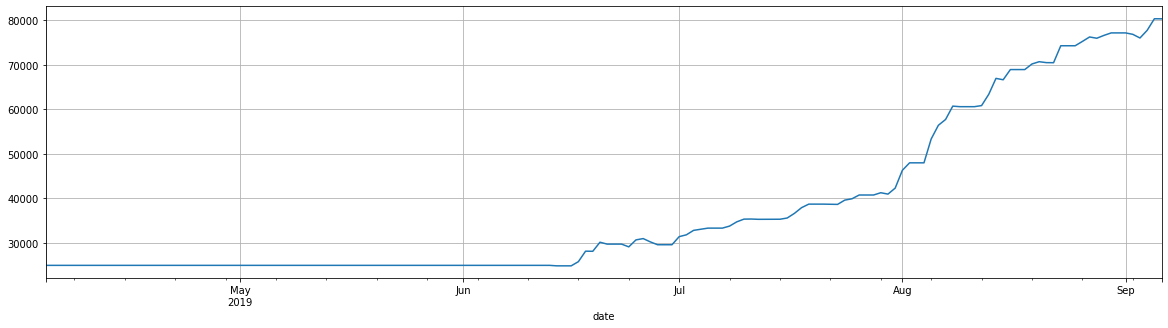

In [107]:
daily.dollars.plot(figsize=(20,5), grid=True);

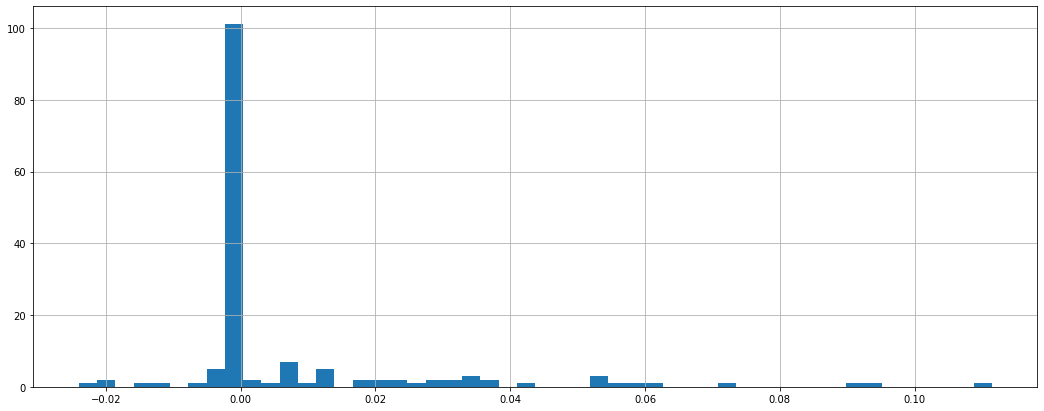

In [108]:
daily['return'].hist(bins=50,figsize=(18,7), grid=True);

In [109]:
daily['dollars_diff'] = daily.dollars.diff()
daily.tail()

,close,pnl,dollars,return,dollars_diff
date,,,,,
2019-09-02,7621.603947,-15.787549,76814.851633,-0.004094,-315.750974
2019-09-03,7612.483673,-41.194952,75990.952591,-0.010726,-823.899043
2019-09-04,7723.209151,86.050983,77711.972252,0.022648,1721.019662
2019-09-05,7857.058754,129.677921,80305.530667,0.033374,2593.558415
2019-09-06,7868.772024,-0.745919,80290.612283,-0.000186,-14.918384


In [110]:
daily['dollars_diff'].sort_values(ascending=True).head(20)

date
2019-09-03   -823.899043
2019-06-27   -745.113797
2019-06-28   -635.294307
2019-06-24   -617.652975
2019-06-21   -423.857174
2019-09-02   -315.750974
2019-07-30   -309.301337
2019-08-15   -308.522282
2019-08-28   -285.079019
2019-08-21   -207.435516
2019-08-09   -122.054840
2019-06-14   -108.719261
2019-07-12    -63.750742
2019-07-22    -35.304153
2019-06-19    -28.098019
2019-07-23    -24.240900
2019-08-22    -18.223241
2019-09-06    -14.918384
2019-04-23      0.000000
2019-07-14      0.000000
Name: dollars_diff, dtype: float64

In [111]:
daily['dollars_diff'].sort_values(ascending=False).head(20)

date
2019-08-05    5349.356532
2019-08-01    3998.819258
2019-08-23    3803.715415
2019-08-14    3559.820363
2019-08-06    3070.346065
2019-08-08    2993.365685
2019-09-05    2593.558415
2019-08-13    2542.001049
2019-06-18    2354.584221
2019-08-16    2286.361043
2019-06-20    2035.318483
2019-07-01    1813.352810
2019-09-04    1721.019662
2019-08-02    1672.748811
2019-06-25    1562.683993
2019-07-31    1341.361470
2019-08-07    1302.487299
2019-07-18    1289.745488
2019-08-19    1252.938866
2019-07-17    1036.088661
Name: dollars_diff, dtype: float64

In [112]:
small = 0
big = []
for i in daily[daily['dollars_diff'] < 0].reset_index().date.diff().eq(pd.Timedelta('1 D')).iteritems():
    if i[1]:
        small += 1
    else:
        if small > 0:
            big.append(small)
            small = 0
print(big)

[1, 1, 1, 1]


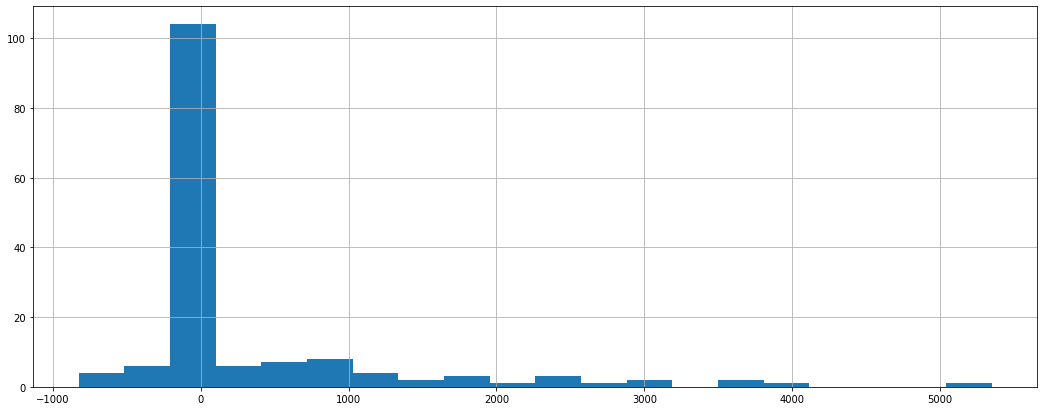

In [113]:
daily['dollars_diff'].hist(bins=20,figsize=(18,7), grid=True);

In [114]:
daily.tail()

,close,pnl,dollars,return,dollars_diff
date,,,,,
2019-09-02,7621.603947,-15.787549,76814.851633,-0.004094,-315.750974
2019-09-03,7612.483673,-41.194952,75990.952591,-0.010726,-823.899043
2019-09-04,7723.209151,86.050983,77711.972252,0.022648,1721.019662
2019-09-05,7857.058754,129.677921,80305.530667,0.033374,2593.558415
2019-09-06,7868.772024,-0.745919,80290.612283,-0.000186,-14.918384


In [115]:
from pyfolio.timeseries import perf_stats

/home/tomek/.virtualenvs/ib/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [116]:
perf_stats(daily['return'])

Annual return            5.584994
Cumulative returns       2.211624
Annual volatility        0.319620
Sharpe ratio             6.109704
Calmar ratio           125.447380
Stability                0.813755
Max drawdown            -0.044521
Omega ratio             10.643640
Sortino ratio           35.077974
Skew                          NaN
Kurtosis                      NaN
Tail ratio              12.883186
Daily value at risk     -0.032519
dtype: float64

In [117]:
(daily['return'] + 1).product()

3.211624491314351

In [118]:
number_of_trades

364

In [119]:
spread = .25 * multiplier
commission = 1.18 + .85 
cost_of_trades = number_of_trades * (spread + commission)
cost_of_trades

2558.9199999999996

In [120]:
days = (daily.index[-1] - daily.index[0]).days #pd.to_datetime('20190613')).days
days

155

In [121]:
trades_per_day = number_of_trades / days
trades_per_day

2.3483870967741933

In [122]:
pnl_in_dollars = pnl*multiplier

In [123]:
cost_of_trades / (pnl_in_dollars)

0.046281274421576965

In [124]:
mean = daily['return'].mean() * 252
std = daily['return'].std() * (252**.5)
mean, std

(1.952785129861189, 0.3196202606387286)

In [125]:
mean/std

6.109703827782213

In [126]:
#daily.to_pickle('cl_return.pickle')